In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

### Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [3]:
ratios = XY.loc[:, lbls].copy()

In [4]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)
#ratios

In [231]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
trainXY = ratios.loc[ratios['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.15)
trainXY.shape

(10972, 15)

In [232]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(trainXY)

In [233]:
trainXY.sample(10)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
39652,agr,698.021882,3.09,6094.03,agr,0.887541,0.009385,0.504720,0.004049,27.112489,13.861825,0.060112,0.184700,0.046212,0.003733
50293,agr,1823.364948,3.63,8450.02,agr,0.829719,0.005082,0.553727,0.005443,37.846021,19.385813,0.058167,0.235731,0.073328,0.010068
11975,pwr,4609.744300,3.69,3991.11,ce14x14,0.699070,0.000288,0.356348,0.002791,10.884703,5.400685,0.022794,0.084745,0.010782,0.000708
12396,pwr,3566.910169,3.69,4174.53,ce14x14,0.747330,0.000738,0.333766,0.002874,11.384790,5.664018,0.029624,0.088131,0.013439,0.000806
22716,pwr,1541.159493,2.99,6215.37,vver1000,0.854098,0.005845,0.283621,0.003616,17.509815,9.018508,0.057641,0.126540,0.032971,0.002338
17151,pwr,1084.073337,2.99,937.48,vver1000,0.863830,0.000881,0.282594,0.001269,2.322785,1.114627,0.013220,0.021692,0.001000,0.000010
48981,agr,3676.586559,3.63,7316.84,agr,0.737182,0.000917,0.621867,0.004874,31.019900,15.870647,0.035733,0.210163,0.044918,0.006625
39177,agr,902.675423,3.09,5947.53,agr,0.875847,0.007700,0.511147,0.003976,27.013575,13.773756,0.056630,0.180899,0.043060,0.003475
12299,pwr,2653.807570,3.69,4174.53,ce14x14,0.791667,0.001613,0.315074,0.002874,11.384790,5.664018,0.036239,0.088144,0.015169,0.000806
23785,pwr,2233.406975,2.99,7553.51,vver1000,0.820976,0.003927,0.296861,0.004133,22.536190,11.569195,0.056015,0.147377,0.042026,0.004069


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [234]:
### If random filtering: make sure sample isn't in training set ###
sim_idx = 55864
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239


In [235]:
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
55864,phwr,2323.256413,0.711,4594.77,candu19


In [10]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [236]:
row_unc = 0.07
test_unc = 0.07
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], row_unc*row), axis=1)
#############################################################################
# pandas converts each row to a series, so using .iloc[0] on the single-row #
# dataframe that is test_sample allows the function to work properly        #
#############################################################################

In [191]:
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (row_unc*row)**2, (test_unc*test_sample)**2), axis=1)

In [192]:
trainXY.sample(10)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239,LogLikelihood,LLUncertainty
7551,pwr,339.667305,3.100,8696.70,ce14x14,0.929389,0.023056,0.262351,0.004483,24.649407,12.443366,0.094431,0.163600,0.070587,0.006279,-371.057122,29.788865
69285,phwr,1338.933836,0.711,6673.83,candu37,0.851446,0.003452,0.320433,0.002406,32.009804,18.362745,0.050207,0.130546,0.014128,0.001065,-191.331458,23.236342
17323,pwr,2724.852694,2.990,937.48,vver1000,0.778723,0.000216,0.313479,0.001269,2.322785,1.114627,0.009208,0.021688,0.000805,0.000010,-71604.488668,7715.405699
45902,agr,2938.430886,3.630,4009.51,agr,0.769192,0.000995,0.590388,0.003151,17.544803,8.474910,0.029029,0.124751,0.016800,0.001133,-151.476301,22.663576
65938,phwr,3011.797820,0.711,3608.70,candu37,0.765628,0.000424,0.366455,0.001659,15.705009,8.426716,0.021625,0.067650,0.003205,0.000148,-186.557821,47.021286
44696,agr,946.527783,3.630,3271.84,agr,0.871286,0.004528,0.519678,0.002748,14.190045,6.665158,0.039079,0.103573,0.014967,0.000621,-237.103866,33.429918
72055,phwr,3885.237712,0.711,8941.48,candu37,0.726525,0.000536,0.368280,0.002979,44.544725,25.952667,0.034833,0.178863,0.018325,0.002805,-269.861939,31.703213
70215,phwr,660.669122,0.711,7060.64,candu37,0.889151,0.006552,0.305889,0.002501,32.539981,18.767639,0.060614,0.138577,0.017343,0.001281,-245.129669,25.371583
72008,phwr,3407.399967,0.711,8941.48,candu37,0.748971,0.000806,0.357243,0.002979,44.544725,25.952667,0.038702,0.178836,0.019516,0.002804,-223.089352,24.381709
9507,pwr,5719.195453,3.690,1609.97,ce14x14,0.646071,0.000038,0.384146,0.001638,4.102804,1.919003,0.008351,0.036526,0.001689,0.000051,-61308.740464,8001.211993


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [193]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: -157.4372082086952 +/- 24.27772598266949


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
21414,pwr,3573.968575,2.99,5249.81,vver1000


#### AGR

In [194]:
max_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].max()
idx_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].idxmax()
unc_agr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_agr])
print(f'Max Log Likelihood for AGRs: {max_agr} +/- {unc_agr}')
trainXY.loc[trainXY.index == idx_agr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for AGRs: -139.53445506390602 +/- 21.63415031503108


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
37386,agr,2958.541112,3.09,4009.51,agr


#### PHWR

In [195]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: 46.24308705423698 +/- 0.8140239363943282


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
55869,phwr,2366.232257,0.711,4594.77,candu19


## LL wrt Burnup and Cool Time

In [237]:
min_ll = trainXY['LogLikelihood'].min()
med_ll = trainXY['LogLikelihood'].median()
mean_ll = trainXY['LogLikelihood'].mean()
max_ll = trainXY['LogLikelihood'].max()
min_ll, med_ll, mean_ll, max_ll

(-294389293.81577957,
 -341.6768014051353,
 -2706428.9601456574,
 46.21185931341729)

In [238]:
plotXY = trainXY.loc[trainXY['LogLikelihood'] > med_ll]
plotXY.shape, trainXY.shape

((5486, 16), (10972, 16))

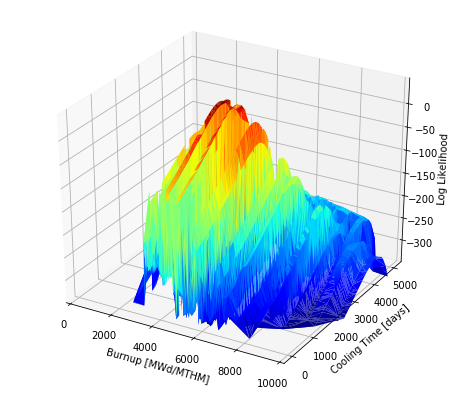

In [239]:
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = plotXY['LogLikelihood']

fig = plt.figure(figsize=(8, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap='jet')#plt.cm.plasma)
#ax.scatter(x,y,z, marker='.', s=5, c='black', alpha=0.2)
#ax.view_init(elev=50, azim=-25)

ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
ax.set_xlim(0, 10000)
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [21]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)
    
    def predict(self, nuc_list):
        
        return burn

In [22]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
X.shape

(14629, 11)

In [24]:
X

,const,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
53806,1.0,0.823392,0.000721,0.342803,0.001343,10.968661,5.628680,0.020296,0.040731,0.001372,3.431042e-05
28420,1.0,0.749728,0.000705,0.335512,0.002772,10.612981,5.221154,0.027415,0.080265,0.010929,5.689857e-04
61655,1.0,0.913999,0.013757,0.284238,0.003233,54.132357,32.032124,0.088586,0.195413,0.033621,3.776233e-03
54166,1.0,0.898284,0.002690,0.313029,0.001412,11.777379,6.193896,0.030624,0.046300,0.002115,5.029059e-05
729,1.0,0.806251,0.000714,0.297304,0.001567,4.238126,1.985237,0.017304,0.036391,0.002463,4.720175e-05
27384,1.0,0.761687,0.000536,0.327977,0.002041,5.970571,2.839640,0.019812,0.050784,0.004537,1.376314e-04
62475,1.0,0.749282,0.000023,0.401342,0.000911,1.344025,0.713399,0.002719,0.006795,0.000037,1.943396e-07
686,1.0,0.828607,0.001036,0.289283,0.001567,4.238126,1.985237,0.019040,0.036408,0.002608,4.718886e-05
66783,1.0,0.847470,0.002108,0.328358,0.001862,19.971751,11.026365,0.036554,0.084623,0.006106,2.880040e-04
53676,1.0,0.892788,0.002162,0.316157,0.001343,10.968661,5.628680,0.026941,0.040748,0.001627,3.431042e-05


In [25]:
mod = NormMod(y, X)

In [26]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 545458.327359
         Iterations: 1704
         Function evaluations: 2503
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -7.9795e+09
Model:                        NormMod   AIC:                         1.596e+10
Method:            Maximum Likelihood   BIC:                         1.596e+10
Date:                Mon, 26 Aug 2019                                         
Time:                        12:39:45                                         
No. Observations:               14629                                         
Df Residuals:                   14618                                         
Df Model:                          10                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [27]:
res.params

array([ 152.78657995,  573.3246519 ,    9.28999576,  296.89667871,
       -466.11324286,  578.71779207, -664.32524069, -397.83215989,
        170.26901221, -109.53584399, -515.51328671])

In [28]:
test_sample.insert(0, 'const', 1.0)

In [29]:
burn_pred = np.sum(test_sample.iloc[0] * res.params)
burn_pred, test_answer['Burnup']

(2692.582140167781, 43552    1604.81
 Name: Burnup, dtype: float64)